<a href="https://colab.research.google.com/github/KishoreKumar1308/MBTI/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as es
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve
import pickle
import warnings
%matplotlib inline
os.chdir("/content/drive/MyDrive/ML Project")
warnings.simplefilter("ignore")

In [ ]:
data_mbti = pd.read_csv("mbti_1.csv")

In [ ]:
print(data_mbti.isnull().sum())

type     0
posts    0
dtype: int64


In [ ]:
print(data_mbti.shape)

(8675, 2)


In [ ]:
print(data_mbti.head())

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


In [ ]:
personalities = data_mbti["type"].unique()
print(personalities)
meanings = ["The Advocate","The Debater","The Thinker","The Inspector","The Commander","The Giver","The Architect","The Performer","The Artist",
            "The Crafter","The Protector","The Inspector","The Persuader","The Performer","The Director","The Caregiver"]

['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


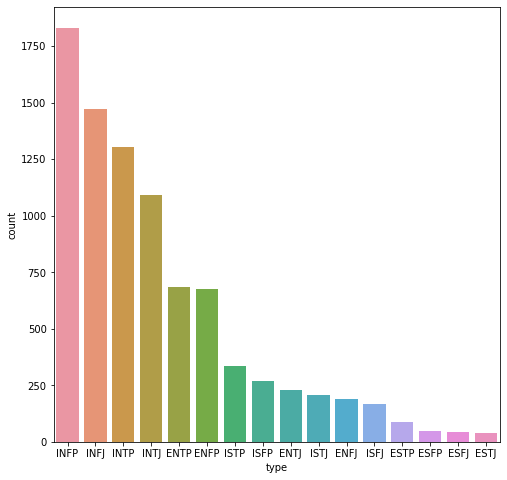

In [ ]:
figure = plt.figure(figsize=(8,8))
sns.countplot(data = data_mbti,x = "type",order = data_mbti["type"].value_counts().index)
plt.show()

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import nltk

nltk.download(["wordnet","punkt","stopwords"])
es_stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Data Visualization

In [ ]:
def create_corpus(data):
    corpus = []
    for text in data.posts.str.split():
        for i in text:
            corpus.append(i)
    return corpus

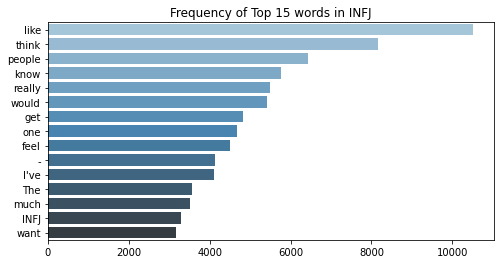

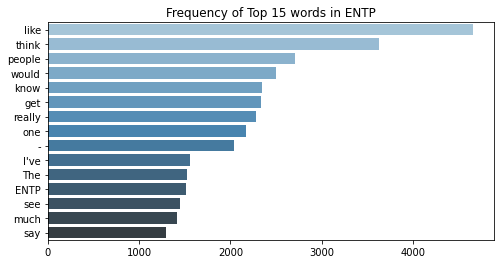

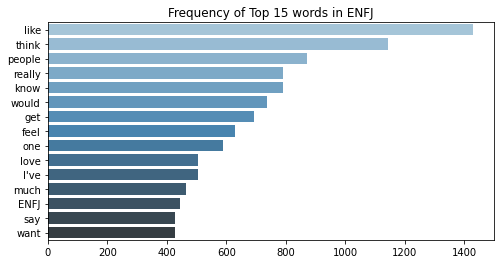

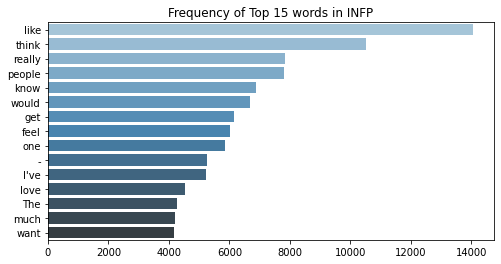

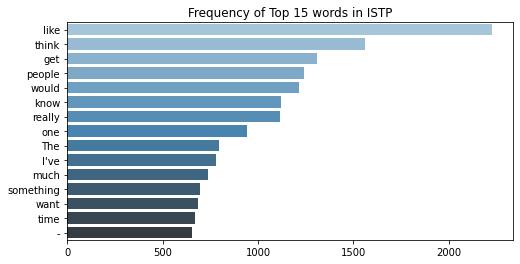

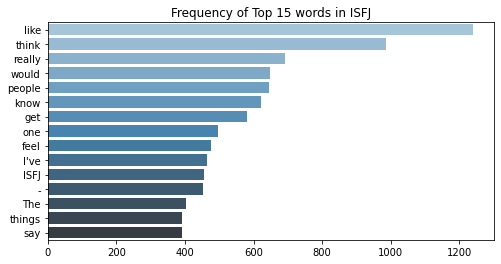

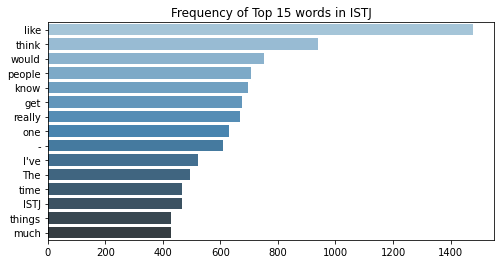

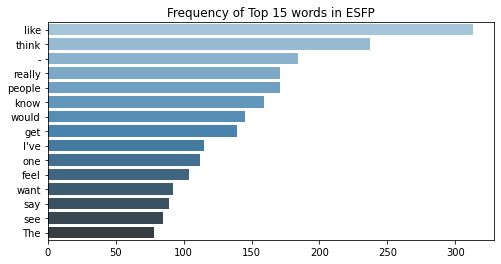

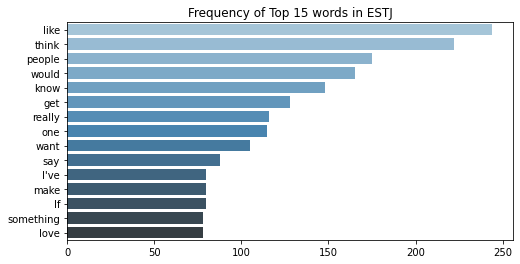

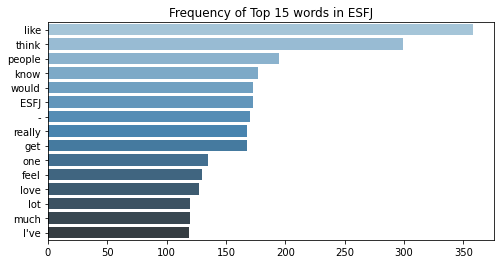

In [ ]:
from collections import defaultdict

def category_top15(category):
    data = data_mbti[data_mbti.type == category]
    corpus = create_corpus(data)
    dic = defaultdict(int)
    for word in corpus:
        if word in es_stop_words:
            dic[word] = 1
        elif word == 'I' or word == "I'm":
            dic[word] = 1 
        else:
            dic[word] += 1

    top = sorted(dic.items() , key = lambda x:x[1] , reverse = True)[:15]
    plt.figure(figsize = (8,4))
    x , y = zip(*top)
    sns.barplot( x = list(y),y = list(x), palette="Blues_d").set(title = 'Frequency of Top 15 words in '+ category)

categories = data_mbti.type.unique()
for i in categories:
    category_top15(i)

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def typewise_properties(pers_type,data = data_mbti):
    personality_data = data[data['type'] == pers_type]
    text = " ".join(personality_data['posts'].tolist())
    wc = WordCloud(background_color="white", max_words=200,  contour_width=3)
    # Generate a wordcloud
    wc.generate(text)
    # show
    plt.figure(figsize=[10,10])
    plt.subplot()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

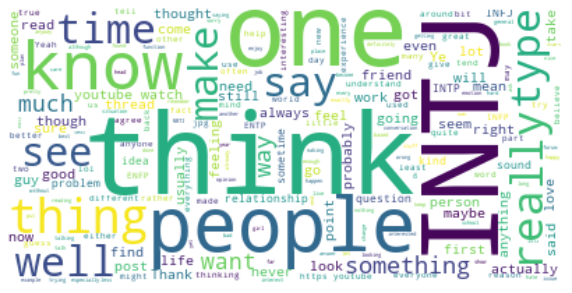

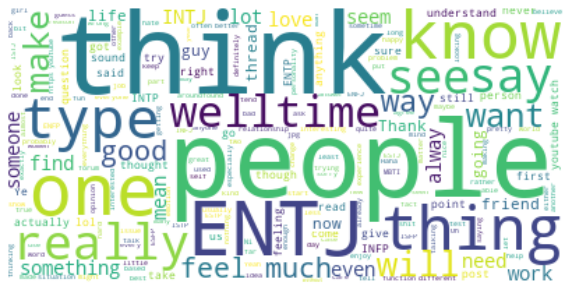

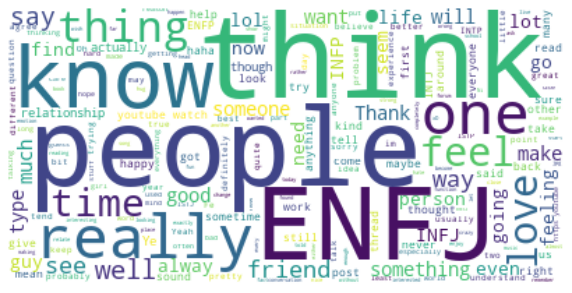

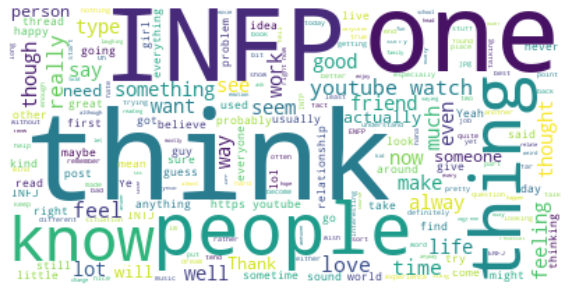

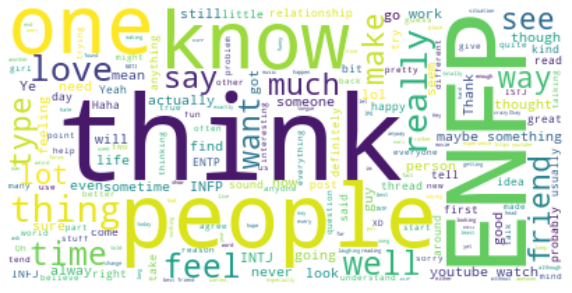

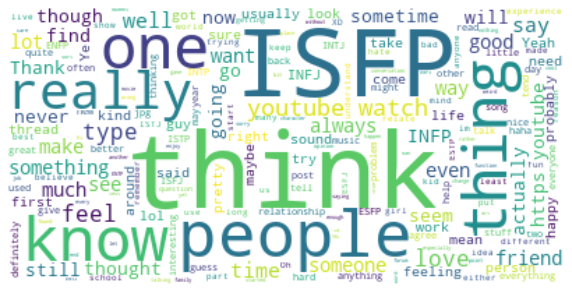

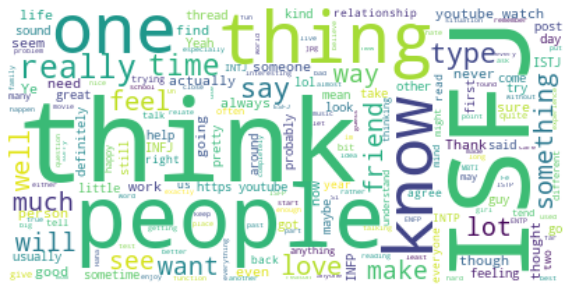

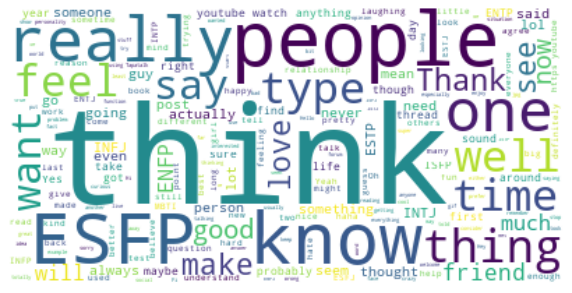

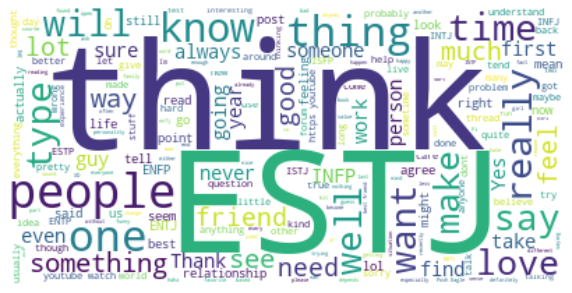

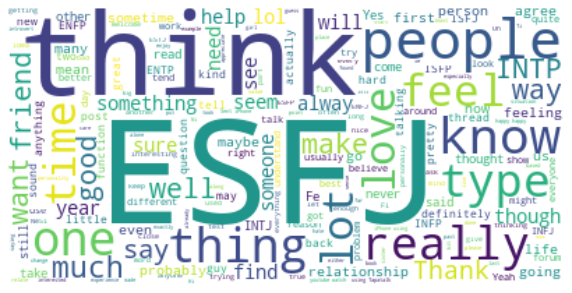

In [ ]:
categories = data_mbti.type.unique()
for i in categories:
    typewise_properties(i)
    print()

#**MBTI Data Preprocessing**

In [ ]:
# Cleaning Data by removing URLs, ||| and other non alphebatic symobls which will have no impact on model building
mbti_posts = data_mbti.posts.replace('+', ' ').replace('.', " ").replace(',', ' ').replace(':', ' ')

# links
for index,post in enumerate(mbti_posts.values):
  mbti_posts.values[index] = re.sub('http\S+', '',post)

# |||
for index,post in enumerate(mbti_posts.values):
  mbti_posts.values[index] = re.sub(r'\|\|\|', r' ',post)

# non alpahbets
for index,post in enumerate(mbti_posts.values):
  mbti_posts.values[index] = re.sub(r'[^a-zA-Z]', r' ',post)

# removing excess spaces 
for index,post in enumerate(mbti_posts.values):
  mbti_posts.values[index] = re.sub(r' +', r' ',post).lower()

mbti_posts = pd.DataFrame(mbti_posts)
data_mbti["Cleaned Posts"] = mbti_posts

In [ ]:
print(data_mbti.head())
X = data_mbti["Cleaned Posts"]
Y = data_mbti["type"]

   type  ...                                      Cleaned Posts
0  INFJ  ...   and intj moments sportscenter not top ten pla...
1  ENTP  ...   i m finding the lack of me in these posts ver...
2  INTP  ...   good one course to which i say i know that s ...
3  INTJ  ...   dear intp i enjoyed our conversation the othe...
4  ENTJ  ...   you re fired that s another silly misconcepti...

[5 rows x 3 columns]


In [ ]:
lemmatizer = WordNetLemmatizer()
snow_stemmer = SnowballStemmer(language='english')

for idx,temp in enumerate(X):
  token_list = word_tokenize(temp)
  filtered_list = [word for word in token_list if not word in es_stop_words]
  temp = " ".join(filtered_list)

  temp = lemmatizer.lemmatize(temp)
  temp = snow_stemmer.stem(temp)
  X[idx] = temp

data_mbti["LematizzedStemed"] = X

In [ ]:
print(data_mbti["LematizzedStemed"].head())

0    intj moments sportscenter top ten plays pranks...
1    finding lack posts alarming sex boring positio...
2    good one course say know blessing curse absolu...
3    dear intp enjoyed conversation day esoteric ga...
4    fired another silly misconception approaching ...
Name: LematizzedStemed, dtype: object


# Normal Naive Bayes model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix
X = data_mbti["LematizzedStemed"]
Y = data_mbti["type"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25,random_state = 268)

X_train = X_train.astype("str")
X_test = X_test.astype("str")
vectorizer = CountVectorizer(tokenizer = str.split, stop_words = es)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

nb = MultinomialNB() 
nb.fit(X_train_vect,y_train)

y_pred = nb.predict(X_test_vect)
pred_proba = nb.predict_proba(X_test_vect)[:,1]

print(X_train.shape)
print(X_test.shape)
print(f"\nModel Accuracy:{accuracy_score(y_test,y_pred)}")
print(np.array(y_test)[0:11])
print(y_pred[0:10])

(6506,)
(2169,)

Model Accuracy:0.40525587828492393
['ENFJ' 'INTJ' 'INFP' 'INFP' 'INFP' 'INFP' 'ENTP' 'INTP' 'INTP' 'INFP'
 'INTP']
['INFP' 'INTP' 'INFP' 'INFP' 'INFP' 'INFP' 'INTP' 'INFP' 'INTP' 'INFJ']


# Checking For Imbalance

In [ ]:
single_type = ['I','N','F','P']
opp_type = ['E','S','T','J']
fig = plt.figure(figsize = (10,10))

for idx,t in enumerate(single_type):
  plt.subplot(2,2,idx+1)
  sns.countplot(x = data_mbti["type"].str.count(t))
  plt.title(f"{opp_type[idx]} Vs {single_type[idx]}")

From the Plots we can see that there is considerable amount of imbalance between I v E and N v S. This is the reason for poor accuracy. Now lets balance the data and build the model.

# Balancing Data with SMOTE (Synthetic Minority over Sampling) and RandomUnderSampling

Sampling is the technique that allows the user to get information about the data based on the statistics of the subset of data

Majority Class - The target class which has more data

Minority Class - The target class with relatively very less number of data

Synthetic Minority Over Sampling Technique - Normal Over Sampling Duplicates minority class, SMOTE creates new Synthetic classes.
Synthetic Classes Generated by taking a minority class and adding other classes that are in nearby k neighbours that are randomly chosen.

SMOTE Paper : https://arxiv.org/pdf/1106.1813.pdf

RandomUnderSampling removes classes randomly from Majority class

## Using CountVectorizer

In [ ]:
# !pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler()

#steps = [('o',over),('u',under)]
#pipeline = Pipeline(steps = steps)
pipeline = Pipeline([('o',over),('u',under)])

X = data_mbti["LematizzedStemed"]
Y = data_mbti["type"]

vectorizer = CountVectorizer(tokenizer = str.split,stop_words = es)
X_vect = vectorizer.fit_transform(X)
pickle.dump(vectorizer,open("Bal-CV.pickle","wb"))

lencoder = LabelEncoder()
Y_enc = lencoder.fit_transform(Y)

X_smote,Y_smote = pipeline.fit_resample(X_vect,Y_enc)

In [ ]:
print(X_vect.shape)
print(Y_enc.shape)

print(X_smote.shape)
print(Y_smote.shape)

encodings = lencoder.inverse_transform(Y_smote)
encodings = pd.Series(encodings)

(8675, 97337)
(8675,)
(29312, 97337)
(29312,)


In [ ]:
single_type = ['I','N','F','P']
opp_type = ['E','S','T','J']
fig = plt.figure(figsize = (10,10))

for idx,t in enumerate(single_type):
  plt.subplot(2,2,idx+1)
  sns.countplot(x = pd.Series(encodings).str.count(t))
  plt.title(f"{opp_type[idx]} Vs {single_type[idx]}")

# Using CountVectorizer

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_smote,Y_smote,test_size = 0.25,random_state = 268)

nb = MultinomialNB()
nb.fit(X_train,y_train)
pickle.dump(nb,open("Bal-CV-1.sav","wb"))
y_pred = nb.predict(X_test)

print(f"\nModel Accuracy:{accuracy_score(y_test,y_pred)}")
y_pred = lencoder.inverse_transform(y_pred)
y_test = lencoder.inverse_transform(y_test)
print(y_test[0:11])
print(y_pred[0:11])


Model Accuracy:0.7771561135371179
['ESTJ' 'INFP' 'ENTP' 'ISTJ' 'ENFJ' 'ENFP' 'INFP' 'INFJ' 'ISTP' 'INTJ'
 'ESFJ']
['ESTJ' 'INFP' 'ENTP' 'INTJ' 'ENFJ' 'ENFP' 'INFP' 'INFJ' 'ISTP' 'INTP'
 'ESFJ']


# Using TF-IDF Vectorizer

In [ ]:
# tfidif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler()

steps = [('o',over),('u',under)]
pipeline = Pipeline(steps = steps)

X = data_mbti["LematizzedStemed"]
Y = data_mbti["type"]

tv = TfidfVectorizer(stop_words = es)
X_vect = tv.fit_transform(X)
pickle.dump(tv,open("Bal-TFIDF.pickle","wb"))

lencoder = LabelEncoder()
Y_enc = lencoder.fit_transform(Y)

X_smote,Y_smote = pipeline.fit_resample(X_vect,Y_enc)

### Naive Bayes Model with Balanced Data using TF-IDF Vectorizer

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_smote,Y_smote,test_size = 0.30,random_state = 268)

nb = MultinomialNB()
nb.fit(X_train,y_train)
pickle.dump(nb,open("Bal-TFIDF-1.sav","wb"))
y_pred = nb.predict(X_test)

print(f"\nModel Accuracy:{accuracy_score(y_test,y_pred)}")
y_pred = lencoder.inverse_transform(y_pred)
y_test = lencoder.inverse_transform(y_test)
print(y_test[0:11])
print(y_pred[0:11])


Model Accuracy:0.8469410962019559
['ESTJ' 'INFP' 'ENTP' 'ISTJ' 'ENFJ' 'ENFP' 'INFP' 'INFJ' 'ISTP' 'INTJ'
 'ESFJ']
['ESTJ' 'INFP' 'ISTP' 'ENTJ' 'ENFJ' 'ENFP' 'ISTP' 'INFJ' 'ISTP' 'INTJ'
 'ESFJ']


# Sampling only Train Data

## Countvectorizer

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler()

steps = [('o',over),('u',under)]
pipeline = Pipeline(steps = steps)

X = data_mbti["LematizzedStemed"]
Y = data_mbti["type"]

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25,random_state = 268)

X_train = X_train.astype("str")
X_test = X_test.astype("str")
vectorizer = CountVectorizer(tokenizer = str.split, stop_words = es)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

lencoder = LabelEncoder()
Y_train_enc = lencoder.fit_transform(y_train)

X_smote,Y_smote = pipeline.fit_resample(X_train_vect,Y_train_enc)

nb = MultinomialNB()
nb.fit(X_smote,Y_smote)

y_pred = nb.predict(X_test_vect)
y_test = lencoder.fit_transform(y_test)
print(f"\nModel Accuracy:{accuracy_score(y_test,y_pred)}")
y_pred = lencoder.inverse_transform(y_pred)
y_test = lencoder.inverse_transform(y_test)
print(y_test[0:11])
print(y_pred[0:11])


Model Accuracy:0.4416781927155371
['ENFJ' 'INTJ' 'INFP' 'INFP' 'INFP' 'INFP' 'ENTP' 'INTP' 'INTP' 'INFP'
 'INTP']
['INFJ' 'INTP' 'INFP' 'INFP' 'INFP' 'INFP' 'INTP' 'INFP' 'INTP' 'INFJ'
 'INFP']


## TFIDF-Vectorizer

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler()

steps = [('o',over),('u',under)]
pipeline = Pipeline(steps = steps)

X = data_mbti["LematizzedStemed"]
Y = data_mbti["type"]

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25,random_state = 268)

X_train = X_train.astype("str")
X_test = X_test.astype("str")
vectorizer = TfidfVectorizer(stop_words = es)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

lencoder = LabelEncoder()
Y_train_enc = lencoder.fit_transform(y_train)

X_smote,Y_smote = pipeline.fit_resample(X_train_vect,Y_train_enc)

nb = MultinomialNB()
nb.fit(X_smote,Y_smote)

y_pred = nb.predict(X_test_vect)
y_test = lencoder.fit_transform(y_test)
print(f"\nModel Accuracy:{accuracy_score(y_test,y_pred)}")
y_pred = lencoder.inverse_transform(y_pred)
y_test = lencoder.inverse_transform(y_test)
print(y_test[0:11])
print(y_pred[0:11])


Model Accuracy:0.47671738128169666
['ENFJ' 'INTJ' 'INFP' 'INFP' 'INFP' 'INFP' 'ENTP' 'INTP' 'INTP' 'INFP'
 'INTP']
['ENTJ' 'INTP' 'INFP' 'INFP' 'ENFJ' 'INFP' 'INTP' 'INFP' 'ISTP' 'INFJ'
 'INFP']


# Predicting For Seperate Personalities (I v E, N v S, F v T, P v J)

In [ ]:
introvert = data_mbti["type"].str.count("I")
intuition = data_mbti["type"].str.count("N")
feeling = data_mbti["type"].str.count("F")
perceiving = data_mbti["type"].str.count("P")

In [ ]:
data_mbti["IvE"] = introvert
data_mbti["NvS"] = intuition
data_mbti["FvT"] = feeling
data_mbti["PvJ"] = perceiving

In [ ]:
data_mbti.head()

type                                              posts  ... FvT PvJ
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...  ...   1   0
1  ENTP  'I'm finding the lack of me in these posts ver...  ...   0   1
2  INTP  'Good one  _____   https://www.youtube.com/wat...  ...   0   1
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...  ...   0   0
4  ENTJ  'You're fired.|||That's another silly misconce...  ...   0   0

[5 rows x 8 columns]

Model For Introvert Vs Extrovert

In [ ]:
X = data_mbti["LematizzedStemed"]
Y = data_mbti["IvE"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25,random_state = 268)

X_train = X_train.astype("str")
X_test = X_test.astype("str")
vectorizer = CountVectorizer(tokenizer = str.split, stop_words = es)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

nb_introvert = MultinomialNB() 
nb_introvert.fit(X_train_vect,y_train)

y_pred = nb_introvert.predict(X_test_vect)
print(f"Model Accuracy:{accuracy_score(y_test,y_pred)}")
print(np.array(y_test)[0:20])
print(y_pred[0:20])

Model Accuracy:0.7883817427385892
[0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


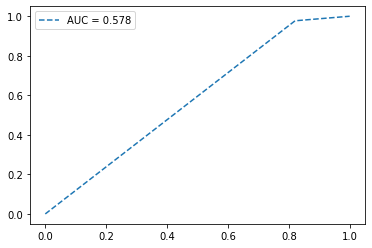

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(y_test, y_pred)
auc1 = auc(false_positive_rate1, true_positive_rate1)

pyplot.plot(false_positive_rate1, true_positive_rate1, linestyle='--', label = 'AUC = %0.3f' %auc1)
pyplot.legend()
pyplot.show()

Model For Intution Vs Sensing

In [ ]:
X = data_mbti["LematizzedStemed"]
Y = data_mbti["NvS"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25,random_state = 268)

X_train = X_train.astype("str")
X_test = X_test.astype("str")
vectorizer = CountVectorizer(tokenizer = str.split, stop_words = es)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

nb_intution = MultinomialNB() 
nb_intution.fit(X_train_vect,y_train)

y_pred = nb_intution.predict(X_test_vect)
print(f"Model Accuracy:{accuracy_score(y_test,y_pred)}")
print(np.array(y_test)[0:20])
print(y_pred[0:20])

Model Accuracy:0.8649147072383587
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


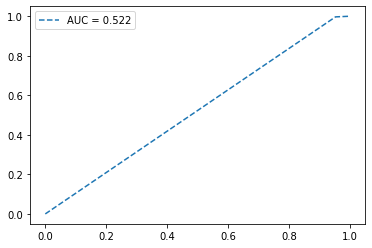

Area under the curve:  <function auc at 0x7ff657a78170>


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(y_test, y_pred)
auc2 = auc(false_positive_rate2, true_positive_rate2)

pyplot.plot(false_positive_rate2, true_positive_rate2, linestyle='--', label = 'AUC = %0.3f' %auc2)
pyplot.legend()
pyplot.show()
print('Area under the curve: ', auc)

Model For Feeling VS Thinking

In [ ]:
X = data_mbti["LematizzedStemed"]
Y = data_mbti["FvT"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25,random_state = 268)

X_train = X_train.astype("str")
X_test = X_test.astype("str")
vectorizer = CountVectorizer(tokenizer = str.split, stop_words = es)
X_train_vect = vectorizer.fit_transform(X_train)
pickle.dump(vectorizer,open("FvT-Vect.pickle","wb"))
X_test_vect = vectorizer.transform(X_test)

nb_feeling = MultinomialNB() 
nb_feeling.fit(X_train_vect,y_train)
pickle.dump(nb_feeling,open("FvT-Model.sav","wb"))
y_pred = nb_feeling.predict(X_test_vect)
print(f"Model Accuracy:{accuracy_score(y_test,y_pred)}")
print(np.array(y_test)[0:20])
print(y_pred[0:20])

Model Accuracy:0.8022130013831259
[1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1]
[0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1]


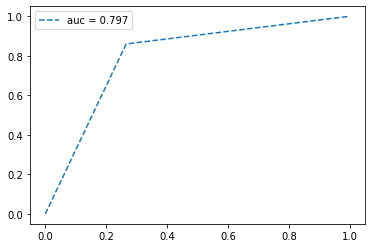

Area under the curve:  0.7969904533584486


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

false_positive_rate3, true_positive_rate3, thresholds3 = roc_curve(y_test, y_pred)
auc3 = auc(false_positive_rate3, true_positive_rate3)

pyplot.plot(false_positive_rate3, true_positive_rate3, linestyle='--', label = 'auc = %0.3f' %auc3)
plt.legend()
pyplot.show()
print('Area under the curve: ', auc3)

Model For Perceiving Vs Judging

In [ ]:
X = data_mbti["LematizzedStemed"]
Y = data_mbti["PvJ"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25,random_state = 268)

X_train = X_train.astype("str")
X_test = X_test.astype("str")
vectorizer = CountVectorizer(tokenizer = str.split, stop_words = es)
X_train_vect = vectorizer.fit_transform(X_train)
pickle.dump(vectorizer,open("PvJ-Vect.pickle","wb"))
X_test_vect = vectorizer.transform(X_test)

nb_perceiving = MultinomialNB() 
nb_perceiving.fit(X_train_vect,y_train)
pickle.dump(nb_perceiving,open("PvJ-Model.sav","wb"))

y_pred = nb_perceiving.predict(X_test_vect)
print(f"Model Accuracy:{accuracy_score(y_test,y_pred)}")
print(np.array(y_test)[0:20])
print(y_pred[0:20])

Model Accuracy:0.7408944213923467
[0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1]
[1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1]


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

false_positive_rate4, true_positive_rate4, thresholds4 = roc_curve(y_test, y_pred)
auc4 = auc(false_positive_rate4, true_positive_rate4)

pyplot.plot(false_positive_rate4, true_positive_rate4, linestyle='--', label = 'auc = %0.3f' %auc4)
pyplot.legend()
pyplot.show()
print('Area under the curve: ', auc4)

Area under the curve:  0.6946841290141544


In [ ]:
pyplot.plot(false_positive_rate1, true_positive_rate1, linestyle = "--", color = "red", label = "I Vs E(%0.3f)" %auc1)
pyplot.plot(false_positive_rate2, true_positive_rate2, linestyle = "--",color = "blue", label = "N Vs S(%0.3f)" %auc2)
pyplot.plot(false_positive_rate3, true_positive_rate3, linestyle = "--",color = "black", label = "T Vs F(%0.3f)" %auc3)
pyplot.plot(false_positive_rate4, true_positive_rate4, linestyle = "--",color = "green", label = "P Vs J(%0.3f)" %auc4)

pyplot.legend()
pyplot.show()

In [ ]:
y_test  = data_mbti["type"]
X_test = data_mbti["LematizzedStemed"].astype("str")

X_test_vect = vectorizer.transform(X_test)

personality_type = [["E","I"],["S","N"],["T","F"],["J","P"]]

IvE = nb_introvert.predict(X_test_vect)
NvS = nb_intution.predict(X_test_vect)
FvT = nb_feeling.predict(X_test_vect)
PvJ = nb_perceiving.predict(X_test_vect)

size = y_test.size
output = [IvE,NvS,FvT,PvJ]

X_prediction = []

for i in range (0,size):
  personality = ""
  for j in range (0,4):
    personality += personality_type[j][output[j][i]]
  X_prediction.append(personality)

X_prediction = np.array(X_prediction)

print(X_prediction[0:20])
print(f"Model Accuracy:{accuracy_score(y_test, X_prediction)}")

['INFJ' 'ENTP' 'INFJ' 'INTJ' 'ENTJ' 'INTJ' 'INFJ' 'INTJ' 'INFJ' 'INTP'
 'INFJ' 'INFP' 'INFP' 'INFJ' 'INTP' 'INTP' 'INFJ' 'INFP' 'INFJ' 'INTP']
Model Accuracy:0.7179250720461096


# Balancing I v E and N v S

In [ ]:
X = data_mbti["LematizzedStemed"]

fig = plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
sns.countplot(x = data_mbti["IvE"])
plt.title("E(0) Vs I(1)")
plt.subplot(1,2,2)
sns.countplot(x = data_mbti["NvS"])
plt.title("S(0) Vs N(1)")
plt.show()

print(data_mbti["IvE"].value_counts())
print(data_mbti["NvS"].value_counts())

1    6676
0    1999
Name: IvE, dtype: int64
1    7478
0    1197
Name: NvS, dtype: int64


I V E

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy = 0.5)
under = RandomUnderSampler()

steps = [('o',over),('u',under)]
pipeline = Pipeline(steps = steps)

X = data_mbti["LematizzedStemed"]
Y = data_mbti["IvE"]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 268)

vectorizer = CountVectorizer(tokenizer = str.split,stop_words = es)
X_train_vect = vectorizer.fit_transform(X_train)
pickle.dump(vectorizer,open("IvE-Vect.pickle","wb"))
X_test_vect = vectorizer.transform(X_test)

lencoder = LabelEncoder()
Y_enc = lencoder.fit_transform(y_train)
Y_test_enc = lencoder.fit_transform(y_test)

X_smote,Y_smote = pipeline.fit_resample(X_train_vect,Y_enc)

In [ ]:
nb_introvert = MultinomialNB() 
nb_introvert.fit(X_smote,Y_smote)
pickle.dump(nb_introvert,open("IvE-Model.sav","wb"))
y_pred = nb_introvert.predict(X_test_vect)
print(f"Model Accuracy:{accuracy_score(Y_test_enc,y_pred)}")
print(np.array(y_test)[0:20])
print(y_pred[0:20])

Model Accuracy:0.7782388197325957
[0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1]
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


N vs S

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy = 0.5)
under = RandomUnderSampler()

steps = [('o',over),('u',under)]
pipeline = Pipeline(steps = steps)

X = data_mbti["LematizzedStemed"]
Y = data_mbti["NvS"]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 268)

vectorizer = CountVectorizer(tokenizer = str.split,stop_words = es)
X_train_vect = vectorizer.fit_transform(X_train)
pickle.dump(vectorizer,open("NvS-Vect.pickle","wb"))
X_test_vect = vectorizer.transform(X_test)

lencoder = LabelEncoder()
Y_enc = lencoder.fit_transform(y_train)
Y_test_enc = lencoder.fit_transform(y_test)

X_smote,Y_smote = pipeline.fit_resample(X_train_vect,Y_enc)

In [ ]:
nb_intuition = MultinomialNB() 
nb_intuition.fit(X_smote,Y_smote)
pickle.dump(nb_intuition,open("NvS-Model.sav","wb"))
y_pred = nb_intuition.predict(X_test_vect)
print(f"Model Accuracy:{accuracy_score(Y_test_enc,y_pred)}")
print(np.array(y_test)[0:20])
print(y_pred[0:20])

Model Accuracy:0.8603042876901799
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# Overall Score after Balancing Seperate classes

In [ ]:
y_test  = data_mbti["type"]
X_test = data_mbti["LematizzedStemed"].astype("str")

X_test_vect = vectorizer.transform(X_test)

personality_type = [["E","I"],["S","N"],["T","F"],["J","P"]]

IvE = nb_introvert.predict(X_test_vect)
NvS = nb_intuition.predict(X_test_vect)
FvT = nb_feeling.predict(X_test_vect)
PvJ = nb_perceiving.predict(X_test_vect)

size = y_test.size
output = [IvE,NvS,FvT,PvJ]

X_prediction = []

for i in range (0,size):
  personality = ""
  for j in range (0,4):
    personality += personality_type[j][output[j][i]]
  X_prediction.append(personality)

X_prediction = np.array(X_prediction)

print(X_prediction[0:20])
print(f"Model Accuracy:{accuracy_score(y_test, X_prediction)}")

['INFJ' 'ENTP' 'INFJ' 'INTJ' 'ENTJ' 'INTJ' 'INFJ' 'INTJ' 'INFJ' 'INTP'
 'INFJ' 'ESFP' 'ESFP' 'INFJ' 'INTP' 'INTP' 'INFJ' 'INFP' 'INFJ' 'INTP']
Model Accuracy:0.7030547550432277


In [ ]:
y_test.size

8675

#KFold

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
cv = RepeatedKFold(n_splits=10, random_state=1,n_repeats = 5)

X = data_mbti["LematizzedStemed"]
target_classes = ["type","IvE","NvS","FvT","PvJ"]
vectorizer = CountVectorizer(tokenizer = str.split, stop_words = es)
X_vect = vectorizer.fit_transform(X)

nb = MultinomialNB()
for target in target_classes:
  scores = cross_val_score(nb,X_vect,data_mbti[target],scoring = "accuracy ",cv = cv,n_jobs = -1)
  print(f"Target Class : {target}\t\tKFold Cross Validation Score : {np.mean(scores)}")

Target Class : type		KFold Cross Validation Score : 0.42176459957797163
Target Class : IvE		KFold Cross Validation Score : 0.7935207479576272
Target Class : NvS		KFold Cross Validation Score : 0.855653399879876
Target Class : FvT		KFold Cross Validation Score : 0.8166240386097513
Target Class : PvJ		KFold Cross Validation Score : 0.7405415145185208


#CNN



In [ ]:
import keras
import tensorflow as tf
from sklearn.utils import class_weight
import tensorflow_hub as hub
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten,Embedding,LSTM,Input
from keras.layers import Conv1D,MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [ ]:
from collections import Counter
count = Counter()
for text in data_mbti["LematizzedStemed"].values:
  for word in text.split():
    count[word] += 1

num_words = len(count)
print(num_words)

freq_word_cnt = 0
d = dict(count)
for value in d:
  if d[value] > 500:
    freq_word_cnt += 1

print(freq_word_cnt)

97544
1572


In [ ]:
X = data_mbti["LematizzedStemed"]
y = data_mbti["IvE"]

In [ ]:
tokenizer = Tokenizer(num_words = 2500)

tokenizer.fit_on_texts(X)
text_sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
text_padded = pad_sequences(text_sequences,maxlen = 2000,padding = "post",truncating = "post")

In [ ]:
embed_index = {}
f = open("glove.6B.100d.txt")
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:],dtype = "float32")
  embed_index[word] = coefs

print(f"Found {len(embed_index)} words")

Found 400000 words


In [ ]:
embed_matrix = np.zeros((len(word_index) + 1,100))
for word,idx in word_index.items():
  embed_vector = embed_index.get(word)
  if embed_vector is not None:
    embed_matrix[idx] = embed_vector

In [ ]:
embed_layer = Embedding(len(word_index) + 1,100,weights = [embed_matrix],input_length = 2000,trainable = False)

In [ ]:
seq_inp = Input(shape = (2000,),dtype = "int32")
embed_seq = embed_layer(seq_inp)
l1 = Conv1D(128,5,activation = "relu")(embed_seq)
l2 = MaxPooling1D(5)(l1)
d = Dropout(0.5)(l2)
l3 = Conv1D(128,5,activation = "relu")(d)
l4 = MaxPooling1D(5)(l3)
d = Dropout(0.5)(l4)
l5 = Conv1D(128,5,activation = "relu")(d)
l6 = MaxPooling1D(35)(l5)
l7 = Flatten()(l6)
l8 = Dense(128,activation = "relu")(l7)
out_layer = Dense(2,activation = "sigmoid")(l8)

Introvert Vs Extrovert

In [ ]:
y_lenc = lencoder.fit_transform(data_mbti["IvE"])
train_labels = to_categorical(y_lenc)
X_train,X_test,y_train,y_test = train_test_split(text_padded,train_labels,test_size = 0.25,random_state = 268)

In [ ]:
model_1 = Model(seq_inp,out_layer)
es = EarlyStopping(monitor = "val_loss",mode = "min",verbose = 1,patience = 2)
model_1.compile(loss = "binary_crossentropy",optimizer = "rmsprop",metrics = ["accuracy"])
model_1.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 15,batch_size = 128,verbose = 2,callbacks = [es])

Epoch 1/15
51/51 - 4s - loss: 0.5952 - accuracy: 0.7654 - val_loss: 0.5883 - val_accuracy: 0.7635
Epoch 2/15
51/51 - 3s - loss: 0.5444 - accuracy: 0.7716 - val_loss: 0.6139 - val_accuracy: 0.7635
Epoch 3/15
51/51 - 3s - loss: 0.5447 - accuracy: 0.7716 - val_loss: 0.5961 - val_accuracy: 0.7635
Epoch 00003: early stopping


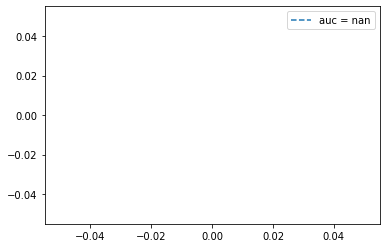

Area under the curve:  nan


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

y_pred = np.array(np.around(model_1.predict(X_test)),dtype = int)

false_positive_rate1,true_positive_rate1,threshold1 = roc_curve(np.argmax(y_pred,axis = -1),np.argmax(y_test,axis = -1))
auc1 = auc(false_positive_rate1,true_positive_rate1)

pyplot.plot(false_positive_rate1, true_positive_rate1, linestyle='--', label = 'auc = %0.3f' %auc1)
plt.legend()
pyplot.show()
print('Area under the curve: ', auc1)

Intuition Vs Sensing

In [ ]:
y_lenc = lencoder.fit_transform(data_mbti["NvS"])
train_labels = to_categorical(y_lenc)
X_train,X_test,y_train,y_test = train_test_split(text_padded,train_labels,test_size = 0.25,random_state = 268)
model_2 = Model(seq_inp,out_layer)
es = EarlyStopping(monitor = "val_loss",mode = "min",verbose = 1,patience = 2)
model_2.compile(loss = "binary_crossentropy",optimizer = "rmsprop",metrics = ["accuracy"])
model_2.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 15,batch_size = 128,verbose = 2,callbacks = [es])

Epoch 1/15
51/51 - 4s - loss: 0.4045 - accuracy: 0.8623 - val_loss: 0.4759 - val_accuracy: 0.8612
Epoch 2/15
51/51 - 3s - loss: 0.3895 - accuracy: 0.8623 - val_loss: 0.3927 - val_accuracy: 0.8612
Epoch 3/15
51/51 - 3s - loss: 0.3857 - accuracy: 0.8623 - val_loss: 0.4864 - val_accuracy: 0.8612
Epoch 4/15
51/51 - 3s - loss: 0.3767 - accuracy: 0.8623 - val_loss: 0.3879 - val_accuracy: 0.8612
Epoch 5/15
51/51 - 3s - loss: 0.3720 - accuracy: 0.8623 - val_loss: 0.4308 - val_accuracy: 0.8612
Epoch 6/15
51/51 - 3s - loss: 0.3672 - accuracy: 0.8623 - val_loss: 0.4074 - val_accuracy: 0.8612
Epoch 00006: early stopping


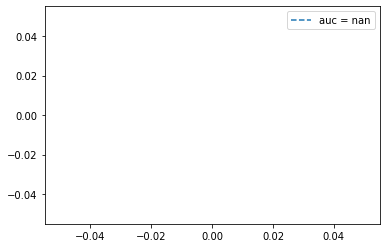

Area under the curve:  nan


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

y_pred = np.array(np.around(model_2.predict(X_test)),dtype = int)

false_positive_rate2,true_positive_rate2,threshold2 = roc_curve(np.argmax(y_pred,axis = -1),np.argmax(y_test,axis = -1))
auc2 = auc(false_positive_rate2,true_positive_rate2)

pyplot.plot(false_positive_rate2, true_positive_rate2, linestyle='--', label = 'auc = %0.3f' %auc2)
plt.legend()
pyplot.show()
print('Area under the curve: ', auc2)

Feeling Vs Thinking

In [ ]:
y_lenc = lencoder.fit_transform(data_mbti["FvT"])
train_labels = to_categorical(y_lenc)
X_train,X_test,y_train,y_test = train_test_split(text_padded,train_labels,test_size = 0.25,random_state = 268)
model_3 = Model(seq_inp,out_layer)
es = EarlyStopping(monitor = "val_loss",mode = "min",verbose = 1,patience = 2)
model_3.compile(loss = "binary_crossentropy",optimizer = "rmsprop",metrics = ["accuracy"])
model_3.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 15,batch_size = 128,verbose = 2,callbacks = [es])

Epoch 1/15
51/51 - 4s - loss: 0.6959 - accuracy: 0.5662 - val_loss: 0.6732 - val_accuracy: 0.6325
Epoch 2/15
51/51 - 3s - loss: 0.6475 - accuracy: 0.6110 - val_loss: 0.6302 - val_accuracy: 0.6459
Epoch 3/15
51/51 - 3s - loss: 0.6197 - accuracy: 0.6519 - val_loss: 0.6977 - val_accuracy: 0.4836
Epoch 4/15
51/51 - 3s - loss: 0.6065 - accuracy: 0.6692 - val_loss: 0.6244 - val_accuracy: 0.6828
Epoch 5/15
51/51 - 3s - loss: 0.5818 - accuracy: 0.6944 - val_loss: 0.7033 - val_accuracy: 0.4873
Epoch 6/15
51/51 - 3s - loss: 0.5829 - accuracy: 0.6924 - val_loss: 0.6935 - val_accuracy: 0.5173
Epoch 00006: early stopping


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

y_pred = np.array(np.around(model_3.predict(X_test)),dtype = int)

false_positive_rate3,true_positive_rate3,threshold3 = roc_curve(np.argmax(y_pred,axis = -1),np.argmax(y_test,axis = -1))
auc3 = auc(false_positive_rate3,true_positive_rate3)

pyplot.plot(false_positive_rate3, true_positive_rate3, linestyle='--', label = 'auc = %0.3f' %auc3)
plt.legend()
pyplot.show()
print('Area under the curve: ', auc3)

Area under the curve:  0.7056611962292336


Perceiving Vs Judging

In [ ]:
y_lenc = lencoder.fit_transform(data_mbti["PvJ"])
train_labels = to_categorical(y_lenc)
X_train,X_test,y_train,y_test = train_test_split(text_padded,train_labels,test_size = 0.25,random_state = 268)
model_4 = Model(seq_inp,out_layer)
es = EarlyStopping(monitor = "val_loss",mode = "min",verbose = 1,patience = 2)
model_4.compile(loss = "binary_crossentropy",optimizer = "rmsprop",metrics = ["accuracy"])
model_4.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 15,batch_size = 128,verbose = 2,callbacks = [es])

Epoch 1/15
51/51 - 4s - loss: 0.6721 - accuracy: 0.6265 - val_loss: 0.6598 - val_accuracy: 0.6289
Epoch 2/15
51/51 - 3s - loss: 0.6489 - accuracy: 0.6400 - val_loss: 0.6635 - val_accuracy: 0.6487
Epoch 3/15
51/51 - 3s - loss: 0.6406 - accuracy: 0.6456 - val_loss: 0.6594 - val_accuracy: 0.6455
Epoch 4/15
51/51 - 3s - loss: 0.6336 - accuracy: 0.6548 - val_loss: 0.6632 - val_accuracy: 0.6478
Epoch 5/15
51/51 - 3s - loss: 0.6293 - accuracy: 0.6575 - val_loss: 0.6739 - val_accuracy: 0.6132
Epoch 00005: early stopping


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

y_pred = np.array(np.around(model_4.predict(X_test)),dtype = int)

false_positive_rate4,true_positive_rate4,threshold4 = roc_curve(np.argmax(y_pred,axis = -1),np.argmax(y_test,axis = -1))
auc4 = auc(false_positive_rate4,true_positive_rate4)

pyplot.plot(false_positive_rate4, true_positive_rate4, linestyle='--', label = 'auc = %0.3f' %auc4)
plt.legend()
pyplot.show()
print('Area under the curve: ', auc4)

Area under the curve:  0.5903935185185185


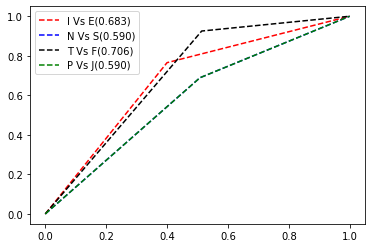

In [ ]:
pyplot.plot(false_positive_rate1,true_positive_rate1,linestyle = "--",color = "red",label = "I Vs E(%0.3f)" %auc1)
pyplot.plot(false_positive_rate2,true_positive_rate2,linestyle = "--",color = "blue",label = "N Vs S(%0.3f)" %auc2)
pyplot.plot(false_positive_rate3,true_positive_rate3,linestyle = "--",color = "black",label = "T Vs F(%0.3f)" %auc3)
pyplot.plot(false_positive_rate4,true_positive_rate4,linestyle = "--",color = "green",label = "P Vs J(%0.3f)" %auc4)

pyplot.legend()
pyplot.show()